In [1]:
from brix import Indicator, Handler
import OpenCity
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
import geopandas as gpd
import urllib
import json
import requests
import math
import osmnx

In [23]:
# import matplotlib.pyplot as plt

# TODO: only consider interactive cells in updates

In [2]:
st=OpenCity.US_State('44', year=2018, geom_type='block')

In [3]:
st.get_geometry()
st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac'])
st.add_lodes_cols_to_shape()

Getting geometry (block) for state: Rhode Island


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Subsetting by urbanized areas
Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data


<AxesSubplot:>

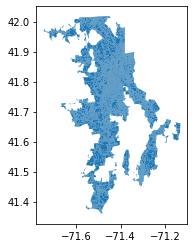

In [4]:
st.geom.plot()

In [ ]:
# TODO: make a base class for proximity and density indicators to elimate repetition
# TODO state only used for state.geom and subsetting thereof- really just need a shape file
# TODO: relevant column names should be in a settings file
# TODO: all US-specific functionality should be in OpenCity

In [154]:
class Proximity_Indicator(Indicator):
    def load(self, state, table_name, buffer=1200):
        self.table_name=table_name
        self.buffer=buffer
        self.state=state
        self.get_geogrid()
        self.get_overlap_geoids()
        self.G=self.get_network_around_geom_buffered(self.geogrid)
        print('Getting central nodes')
        self.state.geom['central_node']=osmnx.get_nearest_nodes(
            self.G, self.state.geom['x_centroid'], self.state.geom['y_centroid'], method='balltree')
        self.geogrid['central_node']=osmnx.get_nearest_nodes(
            self.G, self.geogrid['x_centroid'], self.geogrid['y_centroid'], method='balltree')
        
    def get_geogrid(self):
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            self.geogrid=gpd.read_file(url.read().decode())
        centroids=self.geogrid['geometry'].centroid
        self.geogrid['x_centroid']=[c.x for c in centroids]
        self.geogrid['y_centroid']=[c.y for c in centroids]
                       
    def get_overlap_geoids(self):
        """
        find the geoids of the baseline zones which overlap with hthe geogrid
        
        """
        self.state.geom['copy_GEOID']=self.state.geom.index
        grid_intersect_zones=gpd.overlay(self.geogrid, self.state.geom, 'intersection')
        self.overlapping_geoids=grid_intersect_zones['copy_GEOID'].unique()
         
    def download_graph_around_zone(self, zone):
        """
        Returns the graph within a walkable distance of the centre of the zone
        """
        center_point=[zone['y_centroid'], zone['x_centroid']]
        return osmnx.graph.graph_from_point(center_point, dist=1000, dist_type='network', network_type='walk')
    
    def make_ego_graph_around_geometry(self, zone):
        """
        For geometries within the buffered geogrid only.
        Returns the graph within a walkable distance of the centre of the zone
        """
        sub_graph = osmnx.graph.nx.ego_graph(self.G, zone['central_node'], radius=1200, distance='length')
        return sub_graph
    
    def get_graph_reference_area(self):
        self.state.subset_geom_by_distance(centre_x_y=[self.geogrid.x_centroid.mean(), self.geogrid.y_centroid.mean()], 
                                           radius=2000, name='reference')
        self.reference_zones=self.state.return_geometry(subset_name='reference')
        print('Downloading graph for reference area')
        reference_zone_graph=self.get_network_around_geom_buffered(self.reference_zones)
        self.ref_G=reference_zone_graph
        
    def calculate_baseline_scores(self):
        self.base_scores={'walkable_{}'.format(x): [] for x in [
            'employment', 'housing', 'healthcare', 'hospitality', 'shopping']}
        self.score_ecdfs={}
        for ind, row in self.reference_zones.iterrows():
            # TODO: normalise each score by density at source?
            sub_graph=self.make_ego_graph_around_geometry(row)
            sub_graph_nodes=sub_graph.nodes(data=False)
            reachable_zones= list(self.state.geom.loc[self.state.geom['central_node'].isin(
                list(sub_graph_nodes))].index.values)
            stats_to_aggregate=['total_pop_rac', 'total_employ_wac', 'area']+[
                col for col in self.state.geom.columns if (('naics' in col) or ('income' in col))]
            reachable_area_attributes=self.state.geom.loc[reachable_zones][stats_to_aggregate].sum()
            self.base_scores['walkable_employment'].append(reachable_area_attributes['total_employ_wac'])
            self.base_scores['walkable_housing'].append(reachable_area_attributes['total_pop_rac'])
            self.base_scores['walkable_healthcare'].append(reachable_area_attributes['emp_naics_62'])
            self.base_scores['walkable_hospitality'].append(reachable_area_attributes['emp_naics_72'])
            self.base_scores['walkable_shopping'].append(reachable_area_attributes['emp_naics_44-45'])
        for score in self.base_scores:
            base_scores_no_nan=[x for x in self.base_scores[score] if x==x]
            self.score_ecdfs[score]=ECDF(base_scores_no_nan)
            
    def get_reachable_geoms(self):
        """
        find all grid cells and all zones reachable from each grid cell and each overlapping zone
        """
        for 
#         for every geogrid cell and every overlapping zone
#             find its ego graph
#             find every zone whose central node is in the ego graph
#             find every geoid whose central node is in the ego graph
#             save results

      
    def get_network_around_geom_buffered(self, geom):
        """
        Creates a buffer around the geogrid and downloads the graph for this area
        """
        geom_projected=osmnx.projection.project_gdf(geom)
        geom_projected_buffered=geom_projected.unary_union.buffer(self.buffer)

        geom_projected_buffered_gdf=gpd.GeoDataFrame(geometry=[geom_projected_buffered], crs=geom_projected.crs)
        geom_wgs_buffered_gdf=geom_projected_buffered_gdf.to_crs(geom.crs) 
        
        return osmnx.graph.graph_from_polygon(geom_wgs_buffered_gdf.iloc[0]['geometry'], network_type='walk')

In [155]:
table_name='providence_test'
H=Handler(table_name=table_name)
p=Proximity_Indicator()
p.link_table(table_name=table_name)
H.add_indicator(p)

p.load(state=st, table_name=table_name) 

/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:337: UserWarning: Indicator 0001 has a table linked to it. Remember you do not need to link_table when using the Handler class
  warn(f'Indicator {indicatorName} has a table linked to it. Remember you do not need to link_table when using the Handler class')
<ipython-input-154-405836ba8077>:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geogrid['geometry'].centroid


Getting central nodes


In [156]:
# osmnx.plot.plot_graph(p.G)

In [157]:
p.get_graph_reference_area()
p.calculate_baseline_scores()

	 Subsetting zones by distance


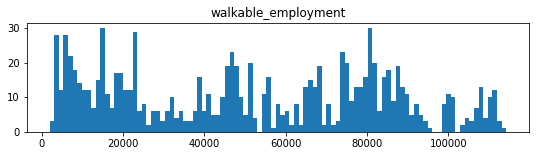

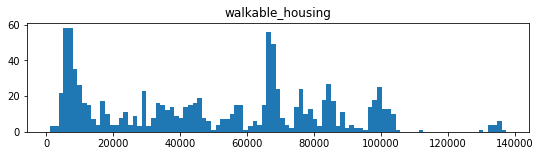

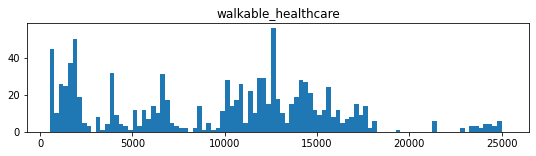

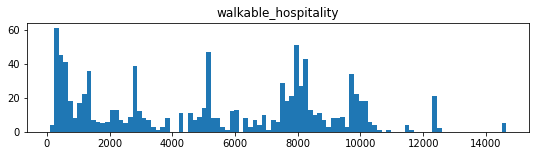

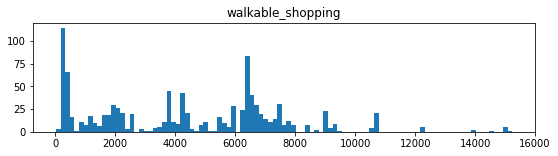

In [165]:
for score in p.base_scores:
    plt.figure(figsize=(9,2))
    min_score, max_score=min(p.base_scores[score]), max(p.base_scores[score])
    _=plt.hist(p.base_scores[score], bins=[min_score+(max_score-min_score)*(x/100) for x in range(100)])
    plt.title(score)

In [79]:
class Density_Indicator(Indicator):
    def load(self, state, table_name_x):
        self.state=state
        self.table_name_x=table_name_x
#         self.requires_geometry=True
        self.grid_cell_area=None
        self.init_geogrid()
        if 'ALAND' in self.state.geom.columns:
            self.state.geom['area']=self.state.geom['ALAND']
        else:
            self.state.geom['area']=self.state.geom['ALAND10']
        self.get_overlap_geoids()
        
    def get_cell_area(self):
        if self.grid_cell_area==None:
            self.grid_cell_area=self.get_table_properties()['cellSize']
        return self.grid_cell_area
    
    def init_geogrid(self):
        """
        initialises the available types on the front-end to a default list from text file
        initialises the GEOGRIDDATA to all "None"
        """
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name_x
        post_url='https://cityio.media.mit.edu/api/table/update/'+self.table_name_x
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid=json.loads(url.read().decode())  
        default_types=json.load(open('data/default_types.json'))
        geogrid['properties']['types']=default_types
        
        geogrid_data=[{
                        "color": [0,0,0,0],
                        "height": [0],
                        "id": i,
                        "interactive": "Web",
                        "name": "None",
                        "tui_id": None
                        } for i in range(len(geogrid['features']))]
        
        r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid))
        print('Initialise GEOGRID: {}'.format(r))
        
        r = requests.post(post_url+'/GEOGRIDDATA', data = json.dumps(geogrid_data))
        print('Initialise GEOGRIDDATA: {}'.format(r))
                
    def compute_base_score_distribution(self):
        """
        computes ECDFs of the indicators across the baseline zones
        the ECDFs are later used to nromalise indicators by finding the percentile rank of the updated site wrt
        the baseline zones
        """
        self.score_ecdfs={}
        self.base_scores={}
        self.base_scores['res_density']=self.state.geom.apply(lambda row: self.res_density(row), axis=1)
        self.base_scores['emp_density']=self.state.geom.apply(lambda row: self.emp_density(row), axis=1)
        self.base_scores['live_work_score']=self.state.geom.apply(
            lambda row: self.get_live_work_score(row), axis=1)
        
        # Diversity
        industry_columns=[col for col in self.state.geom.columns if 'emp_naics' in col]
        res_income_columns=[col for col in self.state.geom.columns if 'res_income' in col]
        
        self.base_scores['industry_diversity']=self.state.geom.apply(
            lambda row: self.get_diversity(row, species_columns=industry_columns), axis=1)
        self.base_scores['income_diversity']=self.state.geom.apply(
            lambda row: self.get_diversity(row, species_columns=res_income_columns), axis=1)
        
        for score in self.base_scores:
#             plt.figure()
#             plt.hist(self.base_scores[score])
#             plt.title(score)
            base_scores_no_nan=[x for x in self.base_scores[score] if x==x]
            self.score_ecdfs[score]=ECDF(base_scores_no_nan)
            
    def get_overlap_geoids(self):
        """
        find the geoids of the baseline zones which overlap with hthe geogrid
        
        """
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name_x
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid=gpd.read_file(url.read().decode())

        self.state.geom['copy_GEOID']=self.state.geom.index
        grid_intersect_zones=gpd.overlay(geogrid, self.state.geom, 'intersection')
        self.overlapping_geoids=grid_intersect_zones['copy_GEOID'].unique()
        
    def combine_site_attributes(self, geogrid_data=None):
        """
        takes the attributes of the geogrid_data (new programming) and 
        the zones which overlap with the geogrid and (pre-existing programming)
        aggregates them together to get the updated site stats
        """
        stats_to_aggregate=['total_pop_rac', 'total_employ_wac', 'area']+[
            col for col in self.state.geom.columns if (('naics' in col) or ('income' in col))]
        temp_site_stats=dict(self.state.geom.loc[self.overlapping_geoids, 
                                                 stats_to_aggregate].sum())
        if geogrid_data is not None:
            agg_types=self.aggregate_types_over_grid(geogrid_data)
            agg_naics=self.aggregate_attributes_over_grid(geogrid_data, 'NAICS', digits=2)
            agg_lbcs=self.aggregate_attributes_over_grid(geogrid_data, 'LBCS', digits=1)
            
            # update total residential and total employment
            add_emp=sum(agg_naics.values())
            if '1' in agg_lbcs:
                add_res=agg_lbcs['1']
            else:
                add_res=0    
            temp_site_stats['total_pop_rac']+=add_res
            temp_site_stats['total_employ_wac']+=add_emp
            
            # update employment for each NAICS code
            for col in temp_site_stats:
                if 'naics' in col:
                    col_naics_codes=col.split('naics_')[1].split('-')
                    for code in col_naics_codes:
                        if code in agg_naics:
                            temp_site_stats[col]+=agg_naics[code]  
                            
            # update residential types
            if 'Residential Low Income' in agg_types:
                temp_site_stats['res_income_u1250_rac']+=agg_types['Residential Low Income']
            if 'Residential Med Income' in agg_types:
                temp_site_stats['res_income_1251-3333_rac']+=agg_types['Residential Med Income']
            if 'Residential High Income' in agg_types:
                temp_site_stats['res_income_3333+_rac']+=agg_types['Residential High Income']          
        return temp_site_stats
    
    def calculate_indicators(self, site_stats):
        raw_ind={}
        raw_ind['res_density']=self.res_density(site_stats)
        raw_ind['emp_density']=self.emp_density(site_stats)
        raw_ind['live_work_score']=self.get_live_work_score(site_stats)
        
        industry_columns=[col for col in self.state.geom.columns if 'emp_naics' in col]
        res_income_columns=[col for col in self.state.geom.columns if 'res_income' in col]
        
        raw_ind['industry_diversity']=self.get_diversity(site_stats, species_columns=industry_columns)
        raw_ind['income_diversity']=self.get_diversity(site_stats, species_columns=res_income_columns)
               
        norm_ind={}
        for ind_name in raw_ind:
            norm_ind[ind_name]=self.score_ecdfs[ind_name](raw_ind[ind_name])       
        return {'raw': raw_ind, 'norm': norm_ind}
                  
    def return_indicator(self, geogrid_data):
        new_site_stats=self.combine_site_attributes(geogrid_data=geogrid_data)
        new_ind=self.calculate_indicators(new_site_stats)
        
        base_site_stats=self.combine_site_attributes(geogrid_data=None)
        base_ind=self.calculate_indicators(base_site_stats)
        
        outputs=[]
        for ind_name in new_ind['raw']:
            outputs.append({'name': ind_name.replace('_', ' ').title(),
                           'raw_value': new_ind['raw'][ind_name],
                           'value': new_ind['norm'][ind_name],
                           'ref_value': base_ind['norm'][ind_name]})
        print(outputs)
        return outputs
    
    def aggregate_types_over_grid(self, geogrid_data):
        side_length=self.get_cell_area()
        cell_area=side_length*side_length
        aggregated={}
        type_def=geogrid_data.get_type_info()  
        for cell in geogrid_data:
            name=cell['name']
            type_info=type_def[name]
            height=cell['height']
            if isinstance(height, list):
                height=height[-1]
            if 'sqm_pperson' in type_info:
                sqm_pperson=type_info['sqm_pperson']
            else:
                sqm_pperson=50
            total_capacity=height*cell_area/sqm_pperson
            if name in aggregated:
                aggregated[name]+=total_capacity
            else:
                aggregated[name]=total_capacity
        return aggregated
                                      
    def aggregate_attributes_over_grid(self, geogrid_data, attribute, digits=None):
        # TODO: eliminate repetition with previous function
        side_length=self.get_cell_area()
        cell_area=side_length*side_length
        aggregated={}
        type_def=geogrid_data.get_type_info()
        for cell in geogrid_data:
            name=cell['name']
            type_info=type_def[name]
            if type_info[attribute] is not None:
                height=cell['height']
                if isinstance(height, list):
                    height=height[-1]
                if 'sqm_pperson' in type_info:
                    sqm_pperson=type_info['sqm_pperson']
                else:
                    sqm_pperson=50
                total_capacity=height*cell_area/sqm_pperson
                for code in type_info[attribute]:
                    if digits==None:
                        code_digits=code
                    else:
                        code_digits=code[0:digits]
                    add_capacity=total_capacity*type_info[attribute][code]
                    if code_digits in aggregated:
                        aggregated[code_digits]+= add_capacity
                    else:
                        aggregated[code_digits]= add_capacity
        return aggregated
        
    @staticmethod
    def res_density(obj):
        """
        input can be a row if the baseline geodataframe
        or a dict representing a dynamic site
        """
        if obj['area']>0:
            return obj['total_pop_rac']/obj['area']
        return 0
    
    @staticmethod
    def emp_density(obj):
        """
        input can be a row if the baseline geodataframe
        or a dict representing a dynamic site
        """
        if obj['area']>0:
            return obj['total_employ_wac']/obj['area'] 
        return 0
    
    @staticmethod
    def get_live_work_score(obj):
        if obj['total_pop_rac'] > obj['total_employ_wac']:
            return obj['total_employ_wac']/obj['total_pop_rac']
        else:
            return obj['total_pop_rac']/obj['total_employ_wac']
     
    @staticmethod
    def get_diversity(obj, species_columns):
        species_counts=[obj[col] for col in species_columns]
        diversity=0
        pop_size=sum(species_counts)
        if ((len(species_counts)>1) and (pop_size>0)):        
            for count in species_counts:
                pj=count/pop_size
                if not pj==0:
                    diversity+= -pj*math.log(pj)
            equitability=diversity/math.log(len(species_counts))
            return equitability
        else:
            return float('nan')

In [36]:
table_name='providence_test'
H=Handler(table_name=table_name)
print(H.table_name)

d=Density_Indicator()
d.link_table(table_name=table_name)
H.add_indicator(d)

d.load(state=st, table_name_x=table_name)
# d.get_geogrid_data() # get new GEOGRID information after init_GEOGRID to ensure tyes are consistent
d.compute_base_score_distribution()


providence_test


/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:337: UserWarning: Indicator 0001 has a table linked to it. Remember you do not need to link_table when using the Handler class
  warn(f'Indicator {indicatorName} has a table linked to it. Remember you do not need to link_table when using the Handler class')
/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:354: UserWarning: Indicator not working: 0001
  warn('Indicator not working: '+indicatorName)


Initialise GEOGRID: <Response [200]>
Initialise GEOGRIDDATA: <Response [200]>


In [38]:
H.listen()

[{'name': 'Res Density', 'raw_value': 0.0023656278848628847, 'value': 0.8355422454441187, 'ref_value': 0.8355422454441187}, {'name': 'Emp Density', 'raw_value': 0.0014831138552767308, 'value': 0.7656729235676604, 'ref_value': 0.7656729235676604}, {'name': 'Live Work Score', 'raw_value': 0.6269430051813472, 'value': 0.8541471048513302, 'ref_value': 0.8541471048513302}, {'name': 'Industry Diversity', 'raw_value': 0.6605829556689482, 'value': 0.9974261717691683, 'ref_value': 0.9974261717691683}, {'name': 'Income Diversity', 'raw_value': 0.9553058412187775, 'value': 0.7142282688827827, 'ref_value': 0.7142282688827827}]
[{'name': 'Res Density', 'raw_value': 0.0023656278848628847, 'value': 0.8355422454441187, 'ref_value': 0.8355422454441187}, {'name': 'Emp Density', 'raw_value': 0.0014831138552767308, 'value': 0.7656729235676604, 'ref_value': 0.7656729235676604}, {'name': 'Live Work Score', 'raw_value': 0.6269430051813472, 'value': 0.8541471048513302, 'ref_value': 0.8541471048513302}, {'name

KeyboardInterrupt: 

In [ ]:
p.